In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from time import time 

import fastai
from fastai.basics import Learner
from fastai.tabular.model import TabularModel
from fastai.tabular.data import TabularDataLoaders
from fastai.metrics import accuracy
from fastai.callback.progress import ProgressCallback

import cudf

import nvtabular as nvt
from nvtabular.ops import Normalize, FillMissing, Categorify, get_embedding_sizes
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.__version__, cudf.__version__, fastai.__version__

('1.6.0', '0+untagged.1.gfa8e9fb', '2.0.16')

In [4]:
%load_ext snakeviz
# load snakeviz if you want to run profiling

<h3> Dataset Gathering: Define files in the training and validation datasets. </h3>

In [5]:
# data_path = '/rapids/notebooks/jperez/Documents/ds-itr/examples/'
INPUT_DATA_DIR = os.environ.get('INPUT_DATA_DIR', '/raid/outbrain1/preprocessed')
OUTPUT_DATA_DIR = os.environ.get('OUTPUT_DATA_DIR', '/raid/outbrain1/output')
BATCH_SIZE = int(os.environ.get('BATCH_SIZE', 400000))
data_path = INPUT_DATA_DIR
#df_test = 'test/'
df_valid = os.path.join(data_path, 'validation_feature_vectors_integral.csv/')
df_train = os.path.join(data_path, 'train_feature_vectors_integral_eval_imputed.csv/')

train_set = [os.path.join(df_train, x) for x in os.listdir(df_train) if x.startswith("part")] 
valid_set = [os.path.join(df_valid, x) for x in os.listdir(df_valid) if x.startswith("part")]

In [6]:
len(train_set), len(valid_set)

(196, 4)

<h4>Grab column information</h4>

In [7]:
cols = open(os.path.join(data_path, 'train_feature_vectors_integral_eval.csv.header')).read().splitlines()

In [8]:
cat_names = ['display_id', 'is_leak', 'doc_event_id', 'ad_id', 'doc_id', 'doc_ad_entity_id', 'doc_event_entity_id', 'doc_event_entity_id', 'doc_ad_source_id', 'doc_event_source_id', 'event_geo_location', 'ad_advertiser', 'event_country_state', 'doc_ad_publisher_id', 'doc_event_publisher_id', 'doc_ad_topic_id', 'doc_event_topic_id', 'event_country', 'doc_ad_category_id', 'doc_event_category_id', 'event_hour', 'event_platform', 'traffic_source', 'event_weekend', 'user_has_already_viewed_doc']
cont_names =  ['pop_ad_id_conf', 'pop_document_id_conf', 'user_doc_ad_sim_categories_conf', 'user_doc_ad_sim_topics_conf', 'pop_publisher_id_conf', 'pop_advertiser_id_conf', 'pop_campaign_id_conf', 'pop_source_id_conf', 'pop_entity_id_conf', 'pop_topic_id_conf', 'pop_category_id_conf', 'pop_ad_id', 'pop_document_id', 'pop_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_source_id', 'pop_entity_id', 'pop_topic_id', 'pop_category_id', 'user_doc_ad_sim_categories', 'user_doc_ad_sim_topics', 'user_doc_ad_sim_entities', 'doc_event_doc_ad_sim_categories', 'doc_event_doc_ad_sim_topics', 'doc_event_doc_ad_sim_entities', 'user_views', 'ad_views', 'doc_views', 'doc_event_days_since_published', 'doc_event_hour', 'doc_ad_days_since_published'] #+ [i for i in ds.columns if i not in cat_names and i not in ['label']]
cat_names = [name for name in cat_names if name in cols]
cont_names = [name for name in cont_names if name in cols]


<h3>Preprocessing:</h3> <p>Select operations to perform, create the Preprocessor object, create dataset iterator object and collect the stats on the training dataset</p>

In [9]:
%%time
proc = nvt.Workflow(cat_names=cat_names, cont_names=cont_names, label_name=['label'])

CPU times: user 8 µs, sys: 21 µs, total: 29 µs
Wall time: 36.7 µs


In [10]:
proc.add_cont_preprocess([FillMissing(), Normalize()])
proc.add_cat_preprocess(Categorify())

In [11]:
%%time
trains_itrs = nvt.Dataset(train_set,names=cols, engine='csv',part_size='100MB')
valids_itrs = nvt.Dataset(valid_set,names=cols, engine='csv',part_size='200MB')

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.59 ms


In [12]:
output_path_train = os.path.join(OUTPUT_DATA_DIR, 'train')
output_path_valid = os.path.join(OUTPUT_DATA_DIR, 'valid')

In [ ]:
%%time
proc.apply(trains_itrs, apply_offline=True, record_stats=True, output_path=output_path_train, shuffle=None)

In [ ]:
%%time
proc.apply(valids_itrs, apply_offline=True, record_stats=False, output_path=output_path_valid, shuffle=None)

In [ ]:
new_train_set = [os.path.join(output_path_train, x) for x in os.listdir(output_path_train) if x.endswith("parquet")]
new_valid_set = [os.path.join(output_path_valid, x) for x in os.listdir(output_path_valid) if x.endswith("parquet")]

<h5>Gather embeddings using statistics gathered in the Read phase.</h5>

In [ ]:
embeddings = list(get_embedding_sizes(proc).values())

In [ ]:
embeddings

<h5>Create the file iterators using the FileItrDataset Class.</h5>

In [ ]:
%%time
t_batch_sets = nvt.Dataset(new_train_set, engine='parquet') 
v_batch_sets = nvt.Dataset(new_valid_set, engine='parquet')

In [ ]:
train_dataset = TorchAsyncItr(t_batch_sets, 
                              batch_size=100000, 
                              cats=cat_names, 
                              conts=cont_names, 
                              labels=["label"])
valid_dataset = TorchAsyncItr(v_batch_sets, 
                              batch_size=50000, 
                              cats=cat_names, 
                              conts=cont_names, 
                              labels=["label"])

<h5>Use the Deep Learning Collator to create a collate function to pass to the dataloader.</h5>

In [ ]:
def gen_col(batch):
    return (batch[0], batch[1], batch[2].long())

In [ ]:
%%time
t_data = DLDataLoader(train_dataset, collate_fn=gen_col, pin_memory=False, num_workers=0)
v_data = DLDataLoader(valid_dataset, collate_fn=gen_col, pin_memory=False, num_workers=0)

<h4>After creating the Dataloaders you can leverage fastai framework to create Machine Learning models</h4>

In [ ]:
databunch = TabularDataLoaders(t_data, v_data, collate_fn=gen_col)

In [ ]:
%%time
model = TabularModel(emb_szs = embeddings, n_cont=len(cont_names), out_sz=2, layers=[512,256])

learn =  Learner(databunch, model, loss_func = torch.nn.CrossEntropyLoss(), metrics=[accuracy], cbs=ProgressCallback())

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.00E-02


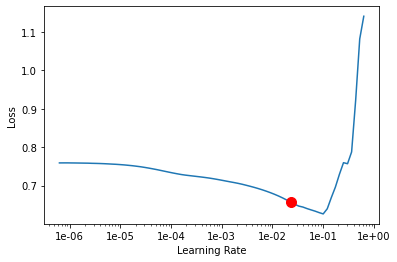

In [25]:
learn.recorder.plot(show_moms=True, suggestion=True)

In [26]:
learning_rate = 2.75e-2
epochs = 1

In [27]:
start = time()
learn.fit_one_cycle(epochs,learning_rate)
t_final = time() - start 

epoch,train_loss,valid_loss,accuracy,time
0,0.419287,0.441445,0.815932,02:20


In [28]:
t_final

140.42356204986572